# nation, state, county growth rate distribution comparison

In [1]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta,datetime
import random
random.seed(3)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import scipy.stats as ss
import json
import warnings
warnings.filterwarnings("ignore")

/Users/fionaguo/.pyenv/versions/3.7.8/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# data import
county_cumsum = pd.read_csv("county_state_data/county_cases_per_100k.csv")
state_cumsum = pd.read_csv("county_state_data/state_cases_per_100k.csv")
nation_cumsum = pd.read_csv("county_state_data/nation_cases_per_100k.csv")[["diff_time","cases","deaths"]]

# county data
county_lst = county_cumsum.groupby(["state","county"]).size().reset_index().rename(columns={0:'county_idx'})
county_lst["county_idx"] = county_lst.index
county_cumsum = pd.merge(county_cumsum,county_lst, on=["state","county"])
counties = {} # record datasets of daily increase
counties_stats = {} # record population, popu density, arrival date, total infected
for i in range(len(county_lst)): # number of counties
    name = county_lst["state"][i] + " " + county_lst["county"][i]
    temp = county_cumsum[county_cumsum["county_idx"]==i]
    temp["di_cases"] = temp["cases"].diff()
    temp["di_deaths"] = temp["deaths"].diff()
    temp.loc[temp["di_cases"]<0,"di_cases"] = 0
    temp.loc[temp["di_deaths"]<0,"di_deaths"] = 0
    temp = temp[1:].reset_index(drop=True)
    # population
    popu = temp["pop_2019"][0]
    area = temp["ALAND"][0]
    popu_den = popu/area
    # days since first case
    infection_dates = temp.loc[temp["cases"]!=0,"diff_time"]
    if len(infection_dates) > 0: # some neighborhoods never had infections up to 04/27
        arrival_date = infection_dates[0]
    else:
        arrival_date = 0
    # tot_infected
    tot_infected = temp["cases"].iloc[-1]
    counties[name] = temp[["diff_time","state","county","cases","deaths","di_cases","di_deaths"]]
    counties_stats[name] = [popu,popu_den,arrival_date,tot_infected]

# state data
states = {}
states_stats = {}
state_lst = pd.unique(state_cumsum["state"])
for i in range(len(state_lst)):
    name = state_lst[i]
    temp = state_cumsum[state_cumsum["state"]==state_lst[i]]
    temp["di_cases"] = temp["cases"].diff()
    temp["di_deaths"] = temp["deaths"].diff()
    temp.loc[temp["di_cases"]<0,"di_cases"] = 0
    temp.loc[temp["di_deaths"]<0,"di_deaths"] = 0
    temp = temp[1:].reset_index(drop=True)
    temp["state_idx"] = i
    # population
    popu = temp["pop_2019"][0]
    area = temp["ALAND"][0]
    popu_den = popu/area
    # days since first case
    infection_dates = temp.loc[temp["cases"]!=0,"diff_time"]
    if len(infection_dates) > 0: # some neighborhoods never had infections up to 04/27
        arrival_date = infection_dates[0]
    else:
        arrival_date = 0
    # tot_infected
    tot_infected = temp["cases"].iloc[-1]
    states[name] = temp[["diff_time","state","cases","deaths","di_cases","di_deaths"]]
    states_stats[name] = [popu,popu_den,arrival_date,tot_infected]

# nation data
nation = nation_cumsum.copy()
nation["di_cases"] = nation["cases"].diff()
nation["di_deaths"] = nation["deaths"].diff()
nation.loc[nation["di_cases"]<0,"di_cases"] = 0
nation.loc[nation["di_deaths"]<0,"di_deaths"] = 0
nation = nation[1:].reset_index(drop=True)

In [4]:
print(len(counties))

2802


In [6]:
def pseudoR2(model,mode = "CU"):
    # input: model: a GLM poisson or NB model
    #        mode: "CU" = Nagelkerke / Cragg & Uhler’s; "McFadden"; "ML" = Maximum Likelihood (Cox & Snell)
    L_f = model.llf # log-likelihood of full model
    L_i = model.llnull # log-likelihood of intercept
    N = model.nobs # number of data points
    
    r2McFadden = 1 - L_f/L_i
    G2 = -2 * (L_i - L_f)
    r2ML = 1 - np.exp(-G2/N)
    r2ML_max = 1 - np.exp(L_i * 2/N)
    r2CU = r2ML/r2ML_max
    if mode == "CU":
        r2 = r2CU
    if mode == "McFadden":
        r2 = r2McFadden
    if mode == "ML":
        r2 = r2ML
    if np.isnan(r2):
        r2 = 0
    return r2


In [7]:
def growthRate(data,data_type,var,mode,pR2_mode,poisson_chi2_cutoff,exp_cutoff = True):
    # input: data - dictionary of pd dataframe or a single pd dataframe
    #        data_type = "dict" or "pd_df"
    #        poisson_expr - str
    #        var - variable (column name in pd dataframe) to be regressed on. eg "di_cases","di_deaths","infections"
    #        mode = "Poisson" or "NB"
    #        pR2_mode = "CU" or "McFadden" or "ML"
    #        poisson_chi2_cutoff - int, if chi2 larger than this, discard this data
    
    # initiate statistics to be recorded
    stats = {}
    stats["outlier"] = 0
    stats["fail_poisson"] = 0
    stats["poisson_insig"] = 0
    stats["nb_insig"] = 0
    stats["high_poisson_chi2"] = 0
    stats["poisson_small_p"] = 0
    stats["nb_small_p"] = 0
    
    poisson_expr = var + """ ~ diff_time"""
    ols_expr = """aux_ols ~ y_lambda - 1"""
    
    if data_type == "pd_df":
        temp_data = data.copy()
        data = {}
        data[0] = temp_data
    
    growth_rates = [] 
    intercepts = []
    subregions_used = []
    pRsquared = []
    std_errs = []
    cut_offs = []
    tot_infected = []
    predictions = {}
    
    for k,v in data.items():
        df = v.copy()
        Y,X = dmatrices(poisson_expr,df,return_type='dataframe')
        total_infect = np.sum(df[var])
        # exclude the outliers
        if len(df[df[var]!=0]) < 5 or total_infect < 30:
            stats["outlier"] += 1
            continue
        if exp_cutoff:
            # cut off upto exp ends using grid search, use the poisson model with best pseudo R^2 
            day_cnt = 0
            n_infected = 0
            pR2 = 0
            poisson = None
            cut_off = 0
            for i in range(len(df[var])):
                if df[var][i] != 0:
                    day_cnt += 1
                    n_infected += df[var][i]
                if day_cnt >= 5 and n_infected > 30:
                    temp = df[:i+1]
                    y,x = dmatrices(poisson_expr,temp,return_type='dataframe')
                    try:
                        temp_model = sm.GLM(y,x,family=sm.families.Poisson()).fit()
                    except:
                        stats["fail_poisson"] += 1
                        continue
                    temp_pR2 = pseudoR2(temp_model,mode=pR2_mode)
                    if temp_pR2 > pR2:
                        pR2 = temp_pR2
                        poisson = temp_model
                        cut_off = i
        else:
            poisson = sm.GLM(Y,X,family=sm.families.Poisson()).fit()
            pR2 = pseudoR2(poisson,mode=pR2_mode)
            cut_off = len(df)
        if pR2 == 0 or poisson == None or cut_off == 0:
            stats["poisson_insig"] += 1
            continue
        # check the significance of poisson regression
#         if poisson.pearson_chi2 > poisson_chi2_cutoff: # curves that don't follow exp trend (threshold 210 is inspected by eyes, not sure)
#             stats["high_poisson_chi2"] += 1
#             print(poisson.pearson_chi2)
#             continue
        if mode == "Poisson":
            if pR2 >= 0.3:
                final_model = poisson
                growth_rate = poisson.params["diff_time"]
                intercept = poisson.params["Intercept"]
                pRs = pR2
                std_err = poisson.bse["diff_time"]
            else:
                stats["poisson_small_p"] += 1
                continue
        else:
            # continue to Negative binomial
            df = df[:cut_off+1]
            y,x = dmatrices(poisson_expr,df,return_type='dataframe')
            # auxiliary OLS to fit the alpha in NB2
            df["y_lambda"] = poisson.mu
            df["aux_ols"] = df.apply(lambda x: ((x['di_cases'] - x['y_lambda'])**2 - x['di_cases']) / x['y_lambda'], axis=1)
            aux_olsr = smf.ols(ols_expr,df).fit()
            try:
                nb = sm.GLM(y,x,family=sm.families.NegativeBinomial(alpha=aux_olsr.params[0])).fit()
            except:
                stats["nb_insig"] += 1
                # use poisson result
                if pR2 >= 0.3:
                    final_model = poisson
                    growth_rate = poisson.params["diff_time"]
                    intercept = poisson.params["Intercept"]
                    pRs = pR2
                    std_err = poisson.bse["diff_time"]
                else:
                    stats["poisson_small_p"] += 1
                    continue
            nb_pR2 = pseudoR2(nb,mode=pR2_mode)
            if nb_pR2 >= 0:
                final_model = nb
                growth_rate = nb.params["diff_time"]
                intercept = nb.params["Intercept"]
                pRs = nb_pR2
                std_err = nb.bse["diff_time"]
            else:
                stats["nb_small_p"] += 1
                continue
        growth_rates.append(growth_rate)
        intercepts.append(intercept)
        subregions_used.append(k)
        pRsquared.append(pRs)
        std_errs.append(std_err)
        cut_offs.append(cut_off)
        tot_infected.append(total_infect)
        predictions[k] = final_model.predict(X)
        
    results = pd.DataFrame({"Growth Rate":growth_rates,"intercepts":intercepts,"pR2":pRsquared,"std_error":std_errs,"cut_offs":cut_offs,"tot_infected":tot_infected},index=subregions_used)
    return [results,predictions,stats]

In [8]:
# county_state_nation growth rate distribution - infected
counties_infected_results,c_i_pred,c_stats = growthRate(counties,"dict","di_cases","NB","McFadden",500)
states_infected_results,s_i_pred,s_stats = growthRate(states,"dict","di_cases","NB","McFadden",500)
nation_infected_results,n_i_pred,n_stats = growthRate(nation,"pd_df","di_cases","NB","McFadden",500)
print("c_stats",c_stats)
print("s_stats",s_stats)
print("n_stats",n_stats)

c_stats {'outlier': 1608, 'fail_poisson': 0, 'poisson_insig': 16, 'nb_insig': 14, 'high_poisson_chi2': 0, 'poisson_small_p': 3, 'nb_small_p': 0}
s_stats {'outlier': 0, 'fail_poisson': 0, 'poisson_insig': 0, 'nb_insig': 0, 'high_poisson_chi2': 0, 'poisson_small_p': 0, 'nb_small_p': 0}
n_stats {'outlier': 0, 'fail_poisson': 0, 'poisson_insig': 0, 'nb_insig': 0, 'high_poisson_chi2': 0, 'poisson_small_p': 0, 'nb_small_p': 0}


Text(0, 0.5, 'Number of infected')

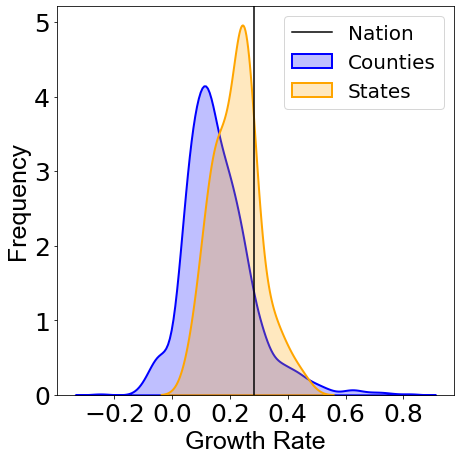

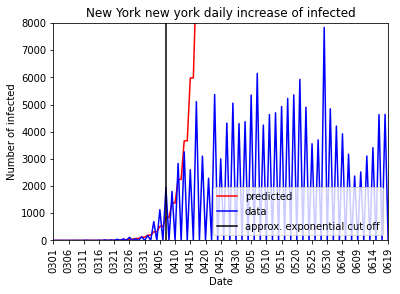

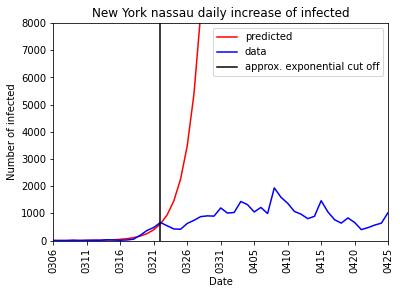

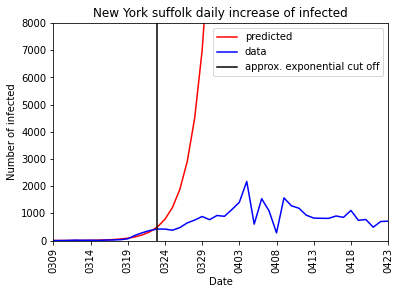

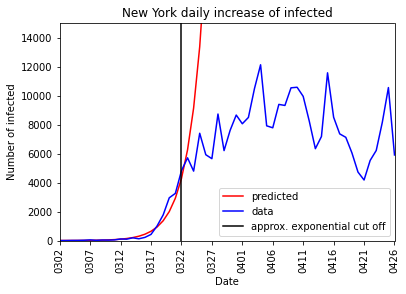

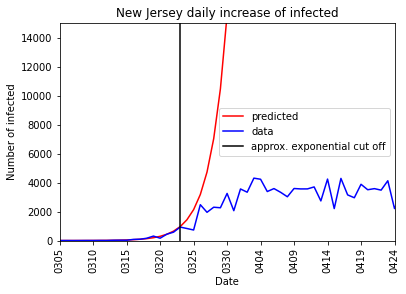

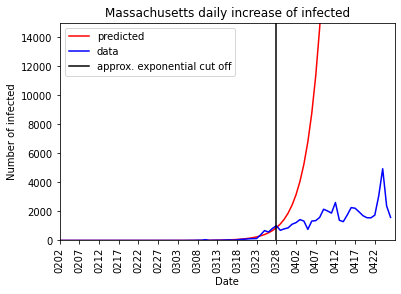

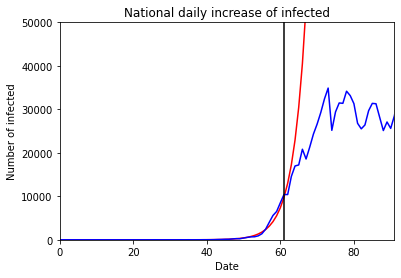

In [12]:
# Figures for Infected - distribution, top infected counties and states growth curve and cutoff
# Figure 1(d)
fig = plt.figure(figsize=[6.5,6.5])
plt.xlabel("Growth Rate",fontname="Arial", fontsize=25)
plt.ylabel("Frequency",fontname="Arial", fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# plt.title("Growth Rates Daily Increase of Infected",fontname="Arial", fontsize=15)
p_c = sns.distplot(counties_infected_results["Growth Rate"],hist=False, kde=True, 
             bins=40, color = "blue",
             kde_kws={'linewidth': 2,"shade": True},label = "Counties")
p_s = sns.distplot(states_infected_results["Growth Rate"], hist=False,kde=True, 
             bins=40, color = "orange",
             kde_kws={'linewidth': 2,"shade": True},label = "States")
p_n = plt.axvline(x=nation_infected_results["Growth Rate"][0],color="black",label="Nation")
# p_a_c = plt.axvline(x=county_agg_growth_rate,color="blue",label="county_agg")
# p_a_s = plt.axvline(x=state_agg_growth_rate,color="green",label="state_agg")
plt.legend(fontsize=20)
plt.tight_layout()

# plot several top counties, states - NB prediction & real data comparison + cut-off date
top_counties = counties_infected_results.sort_values(by=["tot_infected"],ascending=False).index[:3]
top_states = states_infected_results.sort_values(by=["tot_infected"],ascending=False).index[:3]
for c in top_counties:
    start_date = pd.to_timedelta(counties[c]["diff_time"][0],unit="D") + pd.Timestamp('1/1/2020')
    dates = pd.date_range(start=start_date,periods = len(counties[c]["diff_time"]),freq="D")
    dates = dates.format(formatter=lambda x: x.strftime('%m%d'))
    dates = dates[0::5]
    
    plt.figure()
    plt.xlim((0,counties_infected_results["cut_offs"][c]+30))
    plt.ylim((0,8000))
    plt.title(c+" daily increase of infected")
    plt.plot(c_i_pred[c],color="red",label="predicted")
    plt.plot(counties[c]["di_cases"],color = "blue",label="data")
    plt.axvline(x=counties_infected_results["cut_offs"][c],color="black",label="approx. exponential cut off")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Number of infected")
    plt.xticks(ticks = range(0,len(counties[c]["di_cases"]),5),labels=dates,rotation=90)
for s in top_states:
    start_date = pd.to_timedelta(states[s]["diff_time"][0],unit="D") + pd.Timestamp('1/1/2020')
    dates = pd.date_range(start=start_date,periods = len(states[s]["diff_time"]),freq="D")
    dates = dates.format(formatter=lambda x: x.strftime('%m%d'))
    dates = dates[0::5]
    
    plt.figure()
    plt.xlim((0,states_infected_results["cut_offs"][s]+30))
    plt.ylim((0,15000))
    plt.title(s+" daily increase of infected")
    plt.plot(s_i_pred[s],color="red",label="predicted")
    plt.plot(states[s]["di_cases"],color = "blue",label="data")
    plt.axvline(x=states_infected_results["cut_offs"][s],color="black",label="approx. exponential cut off")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Number of infected")
    plt.xticks(ticks = range(0,len(states[s]["di_cases"]),5),labels=dates,rotation=90)
# plot nation - pred & data & cutoff
plt.figure()
plt.xlim((0,nation_infected_results["cut_offs"][0]+30))
plt.ylim((0,50000))
plt.title("National daily increase of infected")
plt.plot(n_i_pred[0],color="red",label="predicted")
plt.plot(nation["di_cases"],color = "blue",label="data")
plt.axvline(x=nation_infected_results["cut_offs"][0],color="black",label="approx. exponential cut off")
plt.xlabel("Date")
plt.ylabel("Number of infected")

In [13]:
# county_state_nation growth rate distribution - deaths
counties_deaths_results,c_d_pred,c_stats = growthRate(counties,"dict","di_deaths","NB","McFadden",500)
states_deaths_results,s_d_pred,s_stats = growthRate(states,"dict","di_deaths","NB","McFadden",500)
nation_deaths_results,n_d_pred,n_stats = growthRate(nation,"pd_df","di_deaths","NB","McFadden",500)
print("c_stats",c_stats)
print("s_stats",s_stats)
print("n_stats",n_stats)

c_stats {'outlier': 2627, 'fail_poisson': 0, 'poisson_insig': 5, 'nb_insig': 0, 'high_poisson_chi2': 0, 'poisson_small_p': 0, 'nb_small_p': 0}
s_stats {'outlier': 6, 'fail_poisson': 0, 'poisson_insig': 0, 'nb_insig': 0, 'high_poisson_chi2': 0, 'poisson_small_p': 0, 'nb_small_p': 0}
n_stats {'outlier': 0, 'fail_poisson': 0, 'poisson_insig': 0, 'nb_insig': 0, 'high_poisson_chi2': 0, 'poisson_small_p': 0, 'nb_small_p': 0}


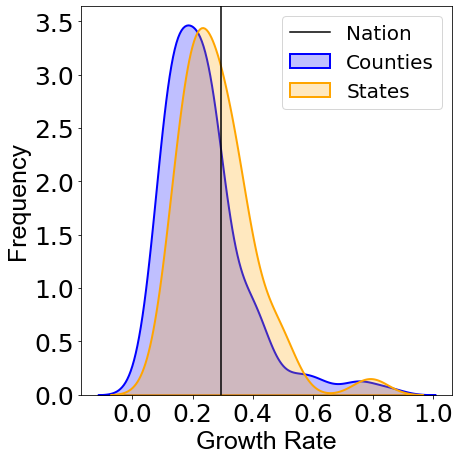

In [16]:
# Figures for Deaths - distribution
# Figure 1(d)
fig = plt.figure(figsize=[6.5,6.5])
plt.xlabel("Death Growth Rate",fontname="Arial", fontsize=25)
plt.ylabel("Frequency",fontname="Arial", fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# plt.title("Growth Rates of Daily Increase of Deaths",fontname="Arial", fontsize=15)
p_c = sns.distplot(counties_deaths_results["Growth Rate"], hist=False, kde=True, 
             bins=40, norm_hist = True, color = "blue",
             kde_kws={'linewidth': 2, "shade":True},label = "Counties")
p_s = sns.distplot(states_deaths_results["Growth Rate"], hist=False, kde=True, 
             bins=40, norm_hist = True, color = "orange",
             kde_kws={'linewidth': 2, "shade":True},label = "States")
p_n = plt.axvline(x=nation_deaths_results["Growth Rate"][0],color="black",label="Nation")
plt.legend(fontsize=20)
plt.tight_layout()

Text(0, 0.5, 'NB fitted growth rate')

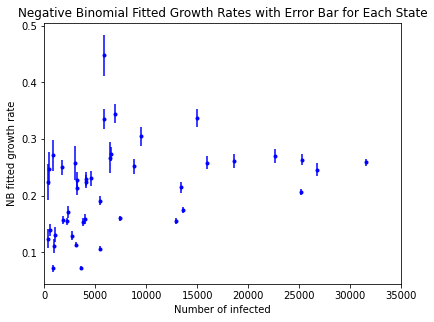

In [18]:
# plot standard error
plt.figure(figsize = [6.4, 4.8])
plt.xlim((0,35000))
plt.title("Negative Binomial Fitted Growth Rates with Error Bar for Each State")
plt.errorbar(states_infected_results["tot_infected"], states_infected_results["Growth Rate"],yerr=states_infected_results["std_error"],fmt = "b.")
plt.xlabel("Number of infected")
plt.ylabel("NB fitted growth rate")

In [22]:
# Spearman's Rank correlation
county_i_matrix = pd.DataFrame({"Growth Rate":counties_infected_results["Growth Rate"],"Population":0,"Population density":0,"Days since first case":pd.Timestamp("2020-01-01"),"Total infected":0},index=counties_infected_results.index)
for n in counties_infected_results.index:
    county_i_matrix.loc[n,"Population"] = counties_stats[n][0]
    county_i_matrix.loc[n,"Population density"] = counties_stats[n][1]
    county_i_matrix.loc[n,"Days since first case"] = 116 - counties_stats[n][2]
    county_i_matrix.loc[n,"Total infected"] = counties_stats[n][3]
c_i_corr,c_i_pval = ss.spearmanr(county_i_matrix)
c_i_corr = c_i_corr[0,1:]
c_i_pval = c_i_pval[0,1:]
print("county infected",c_i_corr,c_i_pval)

county_d_matrix = pd.DataFrame({"Growth Rate":counties_deaths_results["Growth Rate"],"Population":0,"Population density":0,"Days since first case":pd.Timestamp("2020-01-01"),"Total infected":0},index=counties_deaths_results.index)
for n in counties_deaths_results.index:
    county_d_matrix.loc[n,"Population"] = counties_stats[n][0]
    county_d_matrix.loc[n,"Population density"] = counties_stats[n][1]
    county_d_matrix.loc[n,"Days since first case"] = 116 - counties_stats[n][2]
    county_d_matrix.loc[n,"Total infected"] = counties_stats[n][3]
c_d_corr,c_d_pval = ss.spearmanr(county_d_matrix)
c_d_corr = c_d_corr[0,1:]
c_d_pval = c_d_pval[0,1:]
print("county deaths",c_d_corr,c_d_pval)

state_i_matrix = pd.DataFrame({"Growth Rate":states_infected_results["Growth Rate"],"Population":0,"Population density":0,"Days since first case":pd.Timestamp("2020-01-01"),"Total infected":0},index=states_infected_results.index)
for n in states_infected_results.index:
    state_i_matrix.loc[n,"Population"] = states_stats[n][0]
    state_i_matrix.loc[n,"Population density"] = states_stats[n][1]
    state_i_matrix.loc[n,"Days since first case"] = 116 - states_stats[n][2]
    state_i_matrix.loc[n,"Total infected"] = states_stats[n][3]
s_i_corr,s_i_pval = ss.spearmanr(state_i_matrix)
s_i_corr = s_i_corr[0,1:]
s_i_pval = s_i_pval[0,1:]
print("state infected",s_i_corr,s_i_pval)

state_d_matrix = pd.DataFrame({"Growth Rate":states_deaths_results["Growth Rate"],"Population":0,"Population density":0,"Days since first case":pd.Timestamp("2020-01-01"),"Total infected":0},index=states_deaths_results.index)
for n in states_deaths_results.index:
    state_d_matrix.loc[n,"Population"] = states_stats[n][0]
    state_d_matrix.loc[n,"Population density"] = states_stats[n][1]
    state_d_matrix.loc[n,"Days since first case"] = 116 - states_stats[n][2]
    state_d_matrix.loc[n,"Total infected"] = states_stats[n][3]
s_d_corr,s_d_pval = ss.spearmanr(state_d_matrix)
s_d_corr = s_d_corr[0,1:]
s_d_pval = s_d_pval[0,1:]
print("state deaths",s_d_corr,s_d_pval)

county infected [0.30999184 0.28648122 0.26816413 0.60809612] [1.37553156e-027 1.24010266e-023 8.41768142e-021 9.64718257e-120]
county deaths [0.24900556 0.29022905 0.19636271 0.53219786] [1.05881506e-03 1.23449343e-04 1.02759495e-02 8.09087922e-14]
state infected [0.48334842 0.33013575 0.19929289 0.53091699] [3.27052370e-04 1.79839409e-02 1.60896773e-01 6.12312653e-05]
state deaths [0.45006588 0.23596838 0.26006637 0.52913469] [0.001922   0.11863978 0.08447124 0.00018616]
